In [140]:
from gurobipy import *
from passenger import Passenger
import pandas as pd

import matplotlib.pyplot as plt
import itertools
import random

In [132]:
# Load passengers

data_seating = pd.ExcelFile(r'DataSeating.xlsx')
flight_dates = data_seating.sheet_names

flight_data = data_seating.parse(sheet_name = flight_dates[0])
flight_data.drop(flight_data.tail(2).index, inplace=True)
flight_data = flight_data.fillna(0)

In [133]:
#for group in flight_data.iterrows():
    #people = group[1][["Femmes","Hommes","Enfants", "WCHR", "WCHB"]]
    
    #for p in people.index:
        #print(p,people[p],"\n")

In [232]:
passengers = []
passengers.append(Passenger(1,0,"men","Economic"))
passengers.append(Passenger(1,1,"men","Economic"))
passengers.append(Passenger(1,2,"women","Economic"))

passengers.append(Passenger(2,3,"women","Economic"))
passengers.append(Passenger(2,4,"women","Economic"))
passengers.append(Passenger(2,5,"women","Economic"))

passengers.append(Passenger(2,6,"women","Economic"))

groups = {}
for p in passengers:
    if p.group_index in groups.keys():
        groups[p.group_index] = groups[p.group_index] + [p]
    else:
        groups[p.group_index] = [p]
        

passengers_count = len(passengers)

width = 6
height = 28
X = [-3, -2, -1, 0, 1, 2, 3]
Y = list(range(-14,0)) + list(range(1,14+1))

total_weight = sum([p.weight for p in passengers])


In [237]:
m = Model("model_v1")

# Allocation Variables
allocation = m.addVars(len(passengers), width+1, height, vtype=GRB.BINARY, name="Allocation")

satisfaction = m.addVars(len(passengers), vtype=GRB.CONTINUOUS, name="Satisfaction")

#satisfaction_small = (satisfaction[p_id] == sum([ allocation[p_g.passenger_id, i+1, j] * allocation[p_id, i, j] for p_g in groups[p_id] for i in range(width) for j in range(height) ]) for p_id in range(len(passengers)))

def in_grid(i, j):
    return i>=0 and j>=0 and j<height and i <= width

e_allocation = lambda p, i, j: allocation[p,i,j] if in_grid(i,j) else 0

m.addConstrs((satisfaction[p.passenger_id] == 
                sum([e_allocation(p.passenger_id,i,j) * (e_allocation(p_g.passenger_id,i-1,j)+e_allocation(p_g.passenger_id,i+1,j)) 
                for p_g in groups[p.group_index] for i in range(width+1) for j in range(height)])
                for p in passengers if len(groups[p.group_index]) <=3))

m.addConstrs((satisfaction[p.passenger_id] == 
                sum([e_allocation(p.passenger_id,i,j) * 
                (e_allocation(p_g.passenger_id,i-1,j)+e_allocation(p_g.passenger_id,i+1,j) ) 
                for p_g in groups[p.group_index] for i in range(width+1) for j in range(height)])
                for p in passengers if len(groups[p.group_index]) > 3))


{<passenger.Passenger at 0x1b974ae59d0>: <gurobi.QConstr Not Yet Added>,
 <passenger.Passenger at 0x1b974ae5e20>: <gurobi.QConstr Not Yet Added>,
 <passenger.Passenger at 0x1b9738a6d60>: <gurobi.QConstr Not Yet Added>,
 <passenger.Passenger at 0x1b9747b7190>: <gurobi.QConstr Not Yet Added>}

In [229]:

# Make sure that there is at most one person per seat
C_limited_seat = m.addConstrs((sum([allocation[p.passenger_id,i,j] for p in passengers]) <= 1 for i in range(width+1) for j in range(height)))

# Maker sure that everyone is seated and only in one spot
C_serve_all = m.addConstrs((sum([allocation[p.passenger_id,i,j] for i in range(width+1) for j in range(height) ]) == 1 for p in passengers))

C_empty_corridor = m.addConstrs((0 == allocation[p,3,j] for p in range(passengers_count) for j in range(height)))


# Center of Mass function
barycenter_X = sum([p.weight * allocation[p.passenger_id,i,j]*X[i] for p in passengers for i in range(width+1) for j in range(height)])/total_weight
barycenter_Y = sum([p.weight * allocation[p.passenger_id,i,j]*Y[j] for p in passengers for i in range(width+1) for j in range(height)])/total_weight

# Barycenter limits
bary_lim_X = 1
bary_lim_Y = 2

# Make sure that the center of mass is centralized

C_bary_X_p = m.addConstr( barycenter_X <= bary_lim_X)
C_bary_X_m = m.addConstr(barycenter_X >= -bary_lim_X)
C_bary_Y_p = m.addConstr( barycenter_Y <= bary_lim_Y)
C_bary_Y_m = m.addConstr(barycenter_Y >= -bary_lim_Y)


m.setObjective(satisfaction.sum(), GRB.MAXIMIZE)

m.update()


m.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 403 rows, 1379 columns and 8036 nonzeros
Model fingerprint: 0xe9f43378
Model has 7 quadratic constraints
Variable types: 7 continuous, 1372 integer (1372 binary)
Coefficient statistics:
  Matrix range     [1e-01, 2e+00]
  QMatrix range    [1e+00, 2e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 220 rows and 192 columns
Presolve time: 0.02s
Presolved: 6574 rows, 3315 columns, 22853 nonzeros
Variable types: 4 continuous, 3311 integer (3304 binary)
Found heuristic solution: objective -0.0000000

Root relaxation: objective -1.600000e+01, 2448 iterations, 0.06 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node 

Center of Mass: (-0.25, -0.38)
ID:0 - (-1, 5)/(2, 18) Sats: 1.0
ID:1 - (-3, 5)/(0, 18) Sats: 1.0
ID:2 - (-2, 5)/(1, 18) Sats: 2.0
ID:3 - (1, -10)/(4, 4) Sats: 1.0
ID:4 - (3, -10)/(6, 4) Sats: 1.0
ID:5 - (2, -10)/(5, 4) Sats: 2.0
ID:6 - (-1, 10)/(2, 23) Sats: 0.0


(-3.5, 3.5)

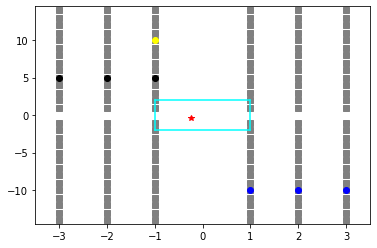

In [230]:
cm_x = round(barycenter_X.getValue(),2)
cm_y = round(barycenter_Y.getValue(),2)

print(f"Center of Mass: {(cm_x, cm_y)}")

#for p in range(passengers_count):
    #print(f"Satisfaction of {p}: {satisfaction[p].x}")

fig = plt.figure();
for seat in itertools.product(X,Y):
    if seat[0] != 0:
        plt.plot(seat[0],seat[1],'s', color="gray")

plt.plot([bary_lim_X, bary_lim_X],[-bary_lim_Y, bary_lim_Y], color="cyan")
plt.plot([-bary_lim_X, -bary_lim_X],[-bary_lim_Y, bary_lim_Y], color="cyan")
plt.plot([-bary_lim_X, bary_lim_X],[bary_lim_Y, bary_lim_Y], color="cyan")
plt.plot([-bary_lim_X, bary_lim_X],[-bary_lim_Y, -bary_lim_Y], color="cyan")

for a in allocation:
    if allocation[a].x == 1:
        #random.seed(passengers[a[0]].group_index*4)
        colors = ["black", "blue", "yellow"]

        
        plt.plot(X[a[1]],Y[a[2]], 'o',color=colors[passengers[a[0]].group_index-1])
        print(f"ID:{a[0]} - {(X[a[1]], Y[a[2]])}/{(a[1], a[2])} Sats: {satisfaction[a[0]].x}")
plt.plot(cm_x,cm_y, "*", color="red")
plt.ylim([-14.5,14.5])
plt.xlim([-3.5,3.5])

In [226]:
print(e_allocation(0,-1, 12))
print(e_allocation(0, 1, 12))
print(e_allocation(1,-1, 12))
print(e_allocation(1, 1, 12))
    
p = passengers[2]


for p_g in groups[p.group_index]:
    if True or p_g.passenger_id != p.passenger_id:
        s = sum([e_allocation(p.passenger_id,i,j) * (e_allocation(p_g.passenger_id,i-1,j)+e_allocation(p_g.passenger_id,i+1,j)) 
                for i in range(width+1) for j in range(height)])

        print(f"{p_g.passenger_id} {s.getValue()}")

0
<gurobi.Var Allocation[0,1,12] (value -0.0)>
0
<gurobi.Var Allocation[1,1,12] (value 0.0)>
1 1.0
2 1.0
3 0.0


In [182]:


#e_allocation = lambda p, i, j: allocation[p,i,j] if in_grid(i,j) else 0

m.addConstrs((satisfaction[p.passenger_id] == 
                sum([e_allocation(p.passenger_id,i,j) * (e_allocation(p_g.passenger_id,i-1,j)+e_allocation(p_g.passenger_id,i+1,j)) 
                for p_g in groups[p.group_index] for i in range(width+1) for j in range(height)])
                for p in passengers))


SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (<ipython-input-182-92d9fe606b56>, line 2)